In [1]:
import matplotlib.pyplot as plt
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from sklearn import datasets
digits = datasets.load_digits()

The input layer requires a 1-dimensional array in input, but our images are 2D. So we need to flatten all images:

In [2]:
x = digits.images.reshape((len(digits.images), -1))
x.shape

(1797, 64)

We now have 1797 flattened images. The two dimensions of our 8x8 images have been collapsed into a single dimension by  writing the rows of 8 pixels as they come, one after the other. The first image that we looked at earlier is now represented by a 1-D array with 8x8 = 64 slots. Please check that the values below are the same as in the original 2-D image. 

In [3]:
x[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [4]:
from keras import backend

Using TensorFlow backend.


One-hot encoding: 

In [5]:
import numpy as np
y = np.zeros((len(digits.target), 10))
y[np.arange(len(digits.target)), digits.target] = 1
print y.shape
print y

(1797, 10)
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]


Can also be done more easily like this: 

In [130]:
from keras.utils import np_utils

In [133]:
y = np_utils.to_categorical(digits.target,10)
print y

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]


let's now split our data into a training sample and a testing sample:

In [110]:
split_limit=1500
x_train = x[:split_limit]
y_train = y[:split_limit]
x_test = x[split_limit:]
y_test = y[split_limit:]

The first 1000 images and labels are going to be used for training. The rest of the dataset will be used later to test the performance of our network. 

We can now create the neural network. We use one hidden layers with 15 neurons. The output layer must have exactly 10 neurons because we want to classify our digits in 10 categories. Don't pay attention to the other parameters, we'll cover that in future posts.

In [111]:
from keras import layers, Model, optimizers

In [122]:
img_input = layers.Input(shape=(64,))
tmp = layers.Dense(50, activation='relu')(img_input)
tmp = layers.Dense(50, activation='relu')(tmp)
output = layers.Dense(10, activation='sigmoid')(tmp)
model = Model(img_input, output)
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=0.001),
              # optimizer=optimizers.Adam(lr=0.1),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 64)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 50)                3250      
_________________________________________________________________
dense_34 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_35 (Dense)             (None, 10)                510       
Total params: 6,310
Trainable params: 6,310
Non-trainable params: 0
_________________________________________________________________


In [123]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=0.001),
              # optimizer=optimizers.Adam(lr=0.1),
              metrics=['accuracy'])

In [124]:
history = model.fit(x=x_train, y=y_train, validation_data=(x_test,y_test),
                    batch_size=20, epochs=10)

Train on 1500 samples, validate on 297 samples
Epoch 1/10
1500/1500 [==============================] - 1s 675us/step - loss: 1.6265 - acc: 0.3100 - val_loss: 0.8877 - val_acc: 0.7239
Epoch 2/10
1500/1500 [==============================] - 0s 110us/step - loss: 0.3676 - acc: 0.8807 - val_loss: 0.5481 - val_acc: 0.8249
Epoch 3/10
1500/1500 [==============================] - 0s 113us/step - loss: 0.1780 - acc: 0.9493 - val_loss: 0.4527 - val_acc: 0.8620
Epoch 4/10
1500/1500 [==============================] - 0s 111us/step - loss: 0.1128 - acc: 0.9673 - val_loss: 0.4105 - val_acc: 0.8855
Epoch 5/10
1500/1500 [==============================] - 0s 108us/step - loss: 0.0881 - acc: 0.9687 - val_loss: 0.3276 - val_acc: 0.8956
Epoch 6/10
1500/1500 [==============================] - 0s 109us/step - loss: 0.0591 - acc: 0.9827 - val_loss: 0.2994 - val_acc: 0.9057
Epoch 7/10
1500/1500 [==============================] - 0s 115us/step - loss: 0.0513 - acc: 0.9860 - val_loss: 0.3873 - val_acc: 0.8822
E

[4.3987693e-08 9.5167493e-08 9.6761347e-08 8.2794031e-07 4.1937245e-09
 1.6790588e-07 1.7083765e-07 3.8774349e-03 2.4869067e-05 1.3916555e-07]


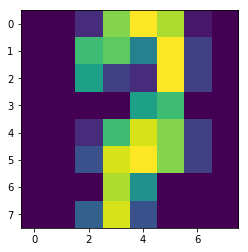

In [125]:
print model.predict(x_test)[1]
img = x_test[1].reshape(8,8)
plt.imshow(img)

In [126]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    # Retrieve a list of list results on training and test data
    # sets for each training epoch
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')

    plt.figure()

    # Plot training and validation loss per epoch
    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    plt.show()
    


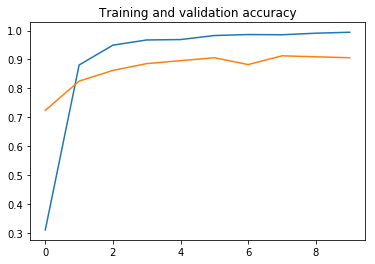

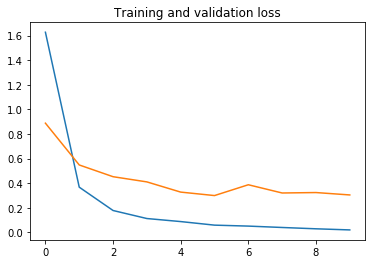

In [127]:
plot_history(history)